In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
df=pd.read_csv('GWB1223.csv')
data = df[(df['Latitude'] == 22.5) & (df['Longitude'] == 88.5)]
data = data.drop(columns=['Latitude', 'Longitude', 'Rain', 'Tmin'])
#data.set_index('Date', inplace=True)
#data = data.asfreq('D')
#print(data.index.freq)
print(data.head())

             Date   Tmax
30681  2012-01-01  27.66
30682  2012-01-02  23.45
30683  2012-01-03  23.82
30684  2012-01-04  23.22
30685  2012-01-05  25.16


In [7]:
#data=data[['Date','Tmax']]
#data=pd.DataFrame(data)
data['Date']=pd.to_datetime(data['Date'])
print(data.head())

            Date   Tmax
30681 2012-01-01  27.66
30682 2012-01-02  23.45
30683 2012-01-03  23.82
30684 2012-01-04  23.22
30685 2012-01-05  25.16


In [9]:
train = data.iloc[:-365]
test = data.iloc[-365:]

In [13]:
df1 = train.set_index('Date')
df2 = data.set_index('Date')
df3 = test.set_index('Date')

monthly_Tmax = df1.resample('ME').mean()
all_monthly_Tmax = df2.resample('ME').mean()
test_plot = df3.resample('ME').mean()
monthly_Tmax.head()

,Tmax
Date,
2012-01-31,24.050323
2012-02-29,29.290690
2012-03-31,33.403226
2012-04-30,34.284667
2012-05-31,36.169032


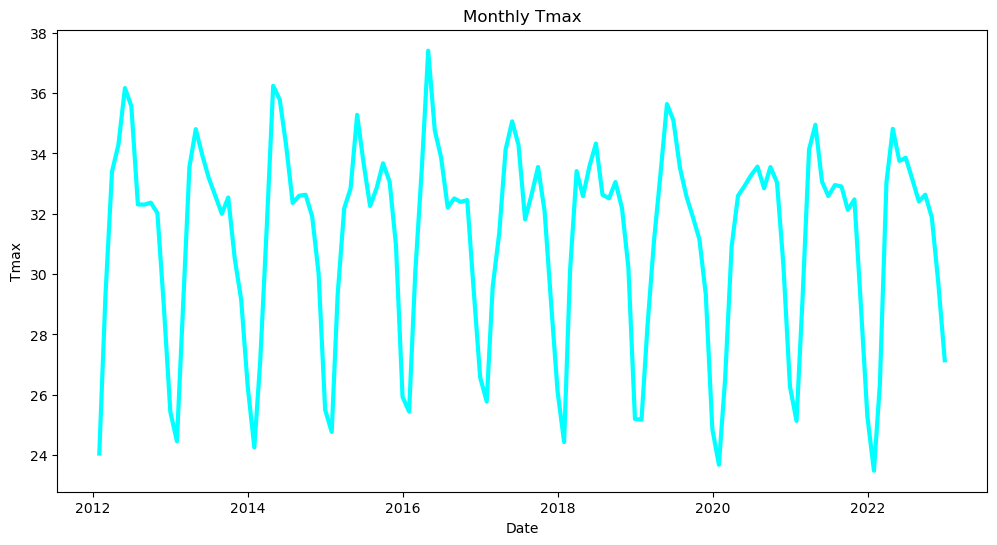

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_Tmax['Tmax'], linewidth=3,c='cyan')
plt.title("Monthly Tmax")
plt.xlabel("Date")
plt.ylabel("Tmax")
plt.show()

In [17]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(monthly_Tmax['Tmax'])

ADF Statistic: -2.5843637804984216
p-value: 0.0962722109815396
Non-Stationary


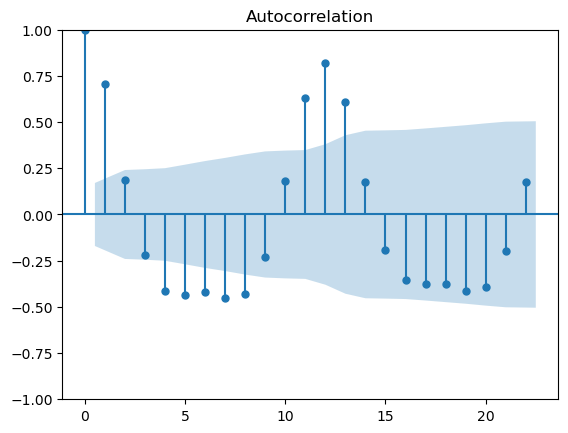

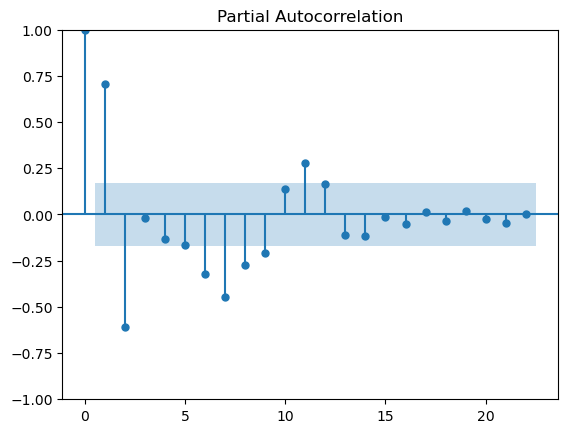

In [19]:
plot_acf(monthly_Tmax)
plot_pacf(monthly_Tmax)
plt.show()

In [21]:
# Define SARIMA parameters
p, d, q = 0, 1, 1
P, D, Q, s = 1, 1, 1, 72 # Assuming 6 month seasonality

# Fit the SARIMA model
model = SARIMAX(monthly_Tmax, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

/home/arpan/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73479D-01    |proj g|=  3.08845D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      7      1     0     0   1.083D-06   7.694D-01
  F =  0.76944778016049942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


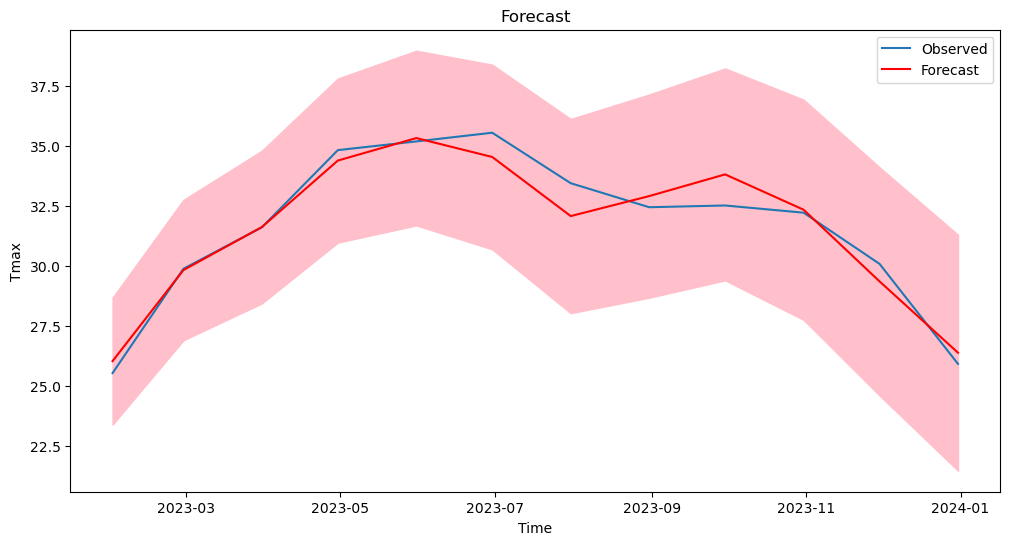

In [38]:
# Forecast future values
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(test_plot, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Forecast")
plt.xlabel("Time")
plt.ylabel("Tmax")
plt.legend()
plt.show()

In [144]:
observed = monthly_Tmax[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 1.208664782793923
MSE: 2.278320865430825
